### Gearbox single node throughput analysis 
#### Peixuan 02052020


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
from datetime import timedelta

In [78]:
class DelayAnalysis:

    def __init__(self, folder, file):
        self.raw_data = self.read_out_tr(folder, file)
        self.tcp_pkt = self.get_tcp_packets(self.raw_data)
        history = self.tcp_pkt.groupby('pkt_id')
        self.duration = (history['time'].last() - history['time'].first()) * 1e6
    def read_out_tr(self, dir, file):
        col = ["events", "time", "from_node", "to_node", "pkt_type", "pkt_size", "flags", "fid", "src_addr", "dst_addr", "seq_num", "pkt_id"]
        df = pd.read_csv(dir+file, sep = ' ', header = None)
        df.columns = col
        return df
    
    def get_tcp_packets(self, df):
        df_out = df.loc[df["pkt_type"].isin(["tcp"])]
        return df_out
    
    def get_pkt_detail_by_pktid(self, id):
        return self.tcp_pkt[tcp_pkt['pkt_id'] == id]
    
    def dropped_pkt_and_id(self):
        history = self.tcp_pkt.groupby('pkt_id')
        dropped_pkt_id = (history['events'].last() == 'd')
        dropped_pkt_id = dropped_pkt_id[dropped_pkt_id]
        dropped = self.tcp_pkt[self.tcp_pkt.pkt_id.isin(dropped_pkt_id.index)]
        dropped.set_index(['pkt_id', dropped.index], inplace = True)
        return dropped, dropped_pkt_id.index.tolist()
    
    def print_pkt_delay(self, rtt):
        # us
        duration = self.duration
        drop_id = self.dropped_pkt_and_id()[1]
        #plt.figure(figsize=(20, 8))
        plt.scatter(duration.index, duration, label='received')
        plt.xlabel('pkt_id')
        plt.ylabel('delay(ms)')
        plt.axhline(y=rtt/2, color='g', linestyle='-')
        plt.scatter(duration[drop_id].index, duration[drop_id], color='r', label='drop')
        plt.legend()
        
    def filter_by_delay(self, boolFunc):
        duration = self.duration
        filter_pkt = tcp_pkt[tcp_pkt.pkt_id.isin(duration[boolFunc].index)]
        filter_pkt.set_index(['pkt_id', filter_pkt.index], inplace = True)
        return filter_pkt

In [2]:
def read_out_tr(dir, file):
    col = ["events", "time", "from_node", "to_node", "pkt_type", "pkt_size", "flags", "fid", "src_addr", "dst_addr", "seq_num", "pkt_id"]
    df = pd.read_csv(dir+file, sep = ' ', header = None)
    df.columns = col
    return df

In [3]:
def get_received_packets(df, node):
    # Getting the reveived tcp pkts at the receiving node
    # node: the number of the receiving node
    df_out = df.loc[df["events"].isin(["r"])]
    df_out = df_out.loc[df_out["pkt_type"].isin(["tcp"])]
    df_out = df_out.loc[df_out["to_node"].isin([node])]
    return df_out

In [4]:
def get_flow_received_packets(df, node, flow_src):
    # Getting the reveived tcp pkts at the receiving node of a certain flow
    # node: the number of the receiving node
    # flow_src: the src node of such flow (node.port)
    df_out = df.loc[df["events"].isin(["r"])]
    df_out = df_out.loc[df_out["pkt_type"].isin(["tcp"])]
    df_out = df_out.loc[df_out["to_node"].isin([node])]
    df_out = df_out.loc[df_out["src_addr"].isin([flow_src])]
    return df_out

In [5]:
# Not useful
def plot_average_throughput(df_out_tr, start_time, node):
    df_out_rec = get_received_packets(df_out_tr, node)
    df_out_rec['data_amount'] = df_out_rec['pkt_size'].cumsum()
    plt.plot(df_out_rec['time'], df_out_rec['data_amount']*8/(df_out_rec['time']-start_time), color='red', label='average_th')

In [6]:
# Not useful
def plot_flow_average_throughput(df_out_tr, start_time, flow_src, node):
    df_out_rec = get_flow_received_packets(df_out_tr, flow_src, node)
    df_out_rec['data_amount'] = df_out_rec['pkt_size'].cumsum()
    plt.plot(df_out_rec['time'], df_out_rec['data_amount']*8/(df_out_rec['time']-start_time), color='red', label='average_th')

In [7]:
# Short-term throughput by Lining
def plot_short_th(df_out_tr, window_size, node):
    # Getting the short-term throughput in a cirtain window size
    # node: the number of the receiving node
    # window_size: the jumping window size observing the short-term window size (in us)
    r_event_in_dst = get_received_packets(df_out_tr, node)
    
    r_event_in_dst['ts'] = r_event_in_dst['time'].apply(lambda x: pd.Timedelta(x,unit='s'))
    
    grouped=r_event_in_dst.groupby('fid')
    
    pkt_size_series = pd.Series(r_event_in_dst['pkt_size'], index=r_event_in_dst['ts'])
    
    # H       hourly frequency
    # T, min  minutely frequency
    # S       secondly frequency
    # L, ms   milliseonds
    # U, us   microseconds
    # N       nanoseconds

    shortTh = grouped[['ts', 'pkt_size']].resample(str(window_size) + 'U', on='ts').sum()
    # Gbps
    shortTh['throughtput'] = shortTh['pkt_size']*8 / (window_size * 1e-6) / 1000 / 1000 / 1000
    ##shortTh.head()
    res = shortTh[['throughtput']].unstack()['throughtput'].T
    res.index = res.index / timedelta(seconds=1)
    res.plot(kind='line', legend=True, title='shortTh')
    plt.xlabel('time')
    plt.ylabel('throughput (GB)')
    plt.show()

In [45]:
# Monitoring queue length by Mengqi
def get_src_packets(df, switch):
    # get all the tcp pkts (Modified by Peixuan)
    df = df.loc[df["events"].isin(["+", "-"])]
    df = df.loc[df["pkt_type"].isin(["tcp"])]
    df = df.loc[df["from_node"].isin([switch])]
    return df

def sort_by_time(df):    
    df = df.sort_values(by=["time", "events"])
    return df

def plot(df):
    plt.figure(figsize=(8,5))
    #plt.plot(x,y,"b--",linewidth=1)   #在当前绘图对象绘图（X轴，Y轴，蓝色虚线，线宽度）
    plt.xlabel("Time")
    plt.ylabel("Queue Length")
    #plt.xscale('log')
    plt.title("Real Time Queue Length")    
    #line0 = plt.plot(df["time"][200:500], df["queue_len"][200:500], color='red', markersize = 12)
    line0 = plt.plot(df["time"], df["queue_len"], color='red')

    plt.legend(loc='best')
    plt.show()

def cal_queue_len(df_out_tr, switch):
    df_queue = get_src_packets(df_out_tr, switch)
    df_queue = sort_by_time(df_queue)
    pktCount = 0
    queue_len = []
    for index, row in df_queue.iterrows():
        if row["events"] == '-': 
            pktCount -= 1
            queue_len.append(pktCount)
        if row["events"] == '+':
            pktCount += 1
            queue_len.append(pktCount)
    df_queue["queue_len"] = queue_len
    plot(df_queue)
    
    #return df_sort

In [74]:
dir = "/home/ovs3/PeixuanGaoWorkspace/Hyline/HyLine/microbenchmark/ns2-simulation/06_single_flow_simulation/"
file = "out.tr"

In [62]:
df_out_tr = read_out_tr(dir, file)

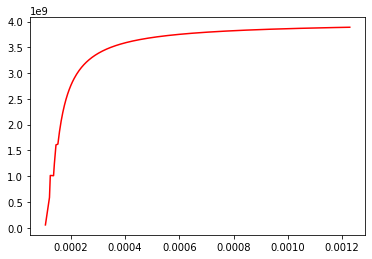

In [63]:
plot_average_throughput(df_out_tr, 0.0001, 5)

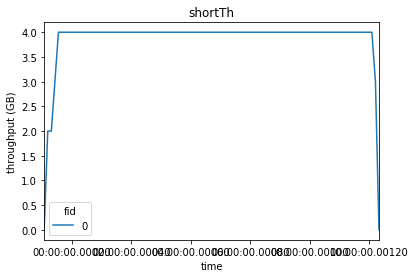

In [64]:
plot_short_th(df_out_tr, 12, 5)

No handles with labels found to put in legend.


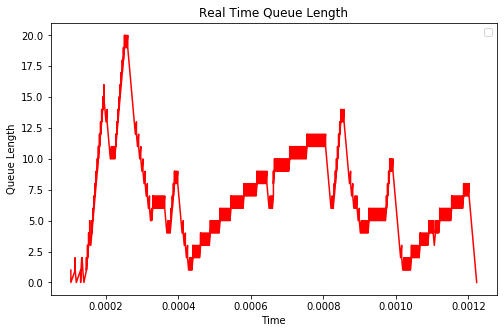

In [65]:
cal_queue_len(df_out_tr, 4)

In [79]:
delayAnalysis = DelayAnalysis(dir, file)

In [72]:
gb['time']